In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set(context='talk', style='darkgrid', palette='deep', font='IPAexGothic', font_scale=1, color_codes=False, rc=None)
from chainer import Chain, Variable, optimizers, using_config
import chainer.links as L
import chainer.functions as F

/home/shuto/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# CNNによる回帰

- 100枚の画像データ(100*100)　&　対応した2次元ベクトルx,y
- 画像データからベクトルを予測する設定

In [2]:
lin = 0.01
x = np.arange(0, 1, lin)
y = np.arange(0, 1, lin)

aa, bb = np.meshgrid(x, y)

In [3]:
Z = []
for i in np.arange(0, 1, lin):
    Z.append((aa-i)**2 + (bb-i)**2)
Z = np.array(Z)

output = np.c_[x, y[-1::-1]]

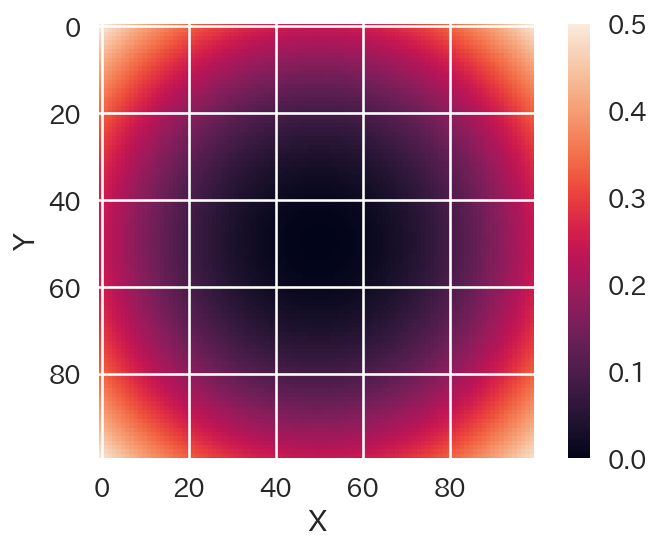

In [7]:
plt.imshow(Z[50])
plt.colorbar () # カラーバーの表示 
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [8]:
x_train = Z.astype(np.float32)
t_train = output.astype(np.float32)

# to (n_sample, channel, height, width)
x_train = x_train.reshape((len(x_train), 1, 100, 100))

In [9]:
class CNN(Chain):
    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 20, 5), # filter 5
            conv2 = L.Convolution2D(20, 50, 5), # filter 5
            l1 = L.Linear(24200, 500),
            l2 = L.Linear(500, 500),
            l3 = L.Linear(500, 2, initialW=np.zeros((2, 500), dtype=np.float32))
        )
    def forward(self, x):
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        return h

In [10]:
model = CNN()
optimizer = optimizers.Adam()
optimizer.setup(model)

In [11]:
N = 100
n_epoch = 20
batch_size = 10
for epoch in range(n_epoch):
    sum_loss = 0
    perm = np.random.permutation(N)
    
    for i in range(0, N, batch_size):
        x = Variable(x_train[perm[i:i+batch_size]])
        t = Variable(t_train[perm[i:i+batch_size]])
        y = model.forward(x)
        model.zerograds()
        loss = F.mean_squared_error(y, t)
        loss.backward()
        optimizer.update()
        sum_loss += loss.data*batch_size

    y = model.forward(x_train)
    RMSE = np.sqrt(F.mean_squared_error(y, t_train).data)
    print("epoch: {}, mean loss: {}, RMSE: {}".format(epoch, sum_loss/N, RMSE))

epoch: 0, mean loss: 0.38181880861520767, RMSE: 0.45717594027519226
epoch: 1, mean loss: 0.1446945808827877, RMSE: 0.32118722796440125
epoch: 2, mean loss: 0.06474054362624884, RMSE: 0.19438041746616364
epoch: 3, mean loss: 0.04747936464846134, RMSE: 0.13352783024311066
epoch: 4, mean loss: 0.02103453266900033, RMSE: 0.16127189993858337
epoch: 5, mean loss: 0.012963957665488125, RMSE: 0.12187854945659637
epoch: 6, mean loss: 0.007812730316072703, RMSE: 0.08325912803411484
epoch: 7, mean loss: 0.0030057456460781395, RMSE: 0.046440672129392624
epoch: 8, mean loss: 0.0011010343208909036, RMSE: 0.029150770977139473
epoch: 9, mean loss: 0.0005351772357244045, RMSE: 0.021428540349006653
epoch: 10, mean loss: 0.00031462777260458095, RMSE: 0.017734739929437637
epoch: 11, mean loss: 0.000172450409445446, RMSE: 0.01061638630926609
epoch: 12, mean loss: 0.00010038751279353164, RMSE: 0.008685415610671043
epoch: 13, mean loss: 8.05957233751542e-05, RMSE: 0.010447232984006405
epoch: 14, mean loss: 0

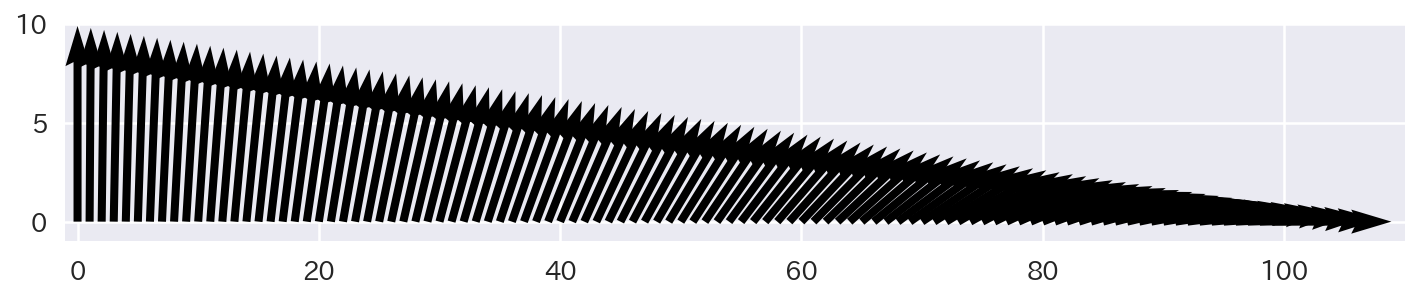

In [14]:
# 正解ベクトル
plt.figure(figsize=(12,2))
plt.quiver(t_train[:,0], t_train[:,1], angles='xy', scale_units='xy', scale=0.1)
plt.xlim([-1,110])
plt.ylim([-1,10])
plt.show()

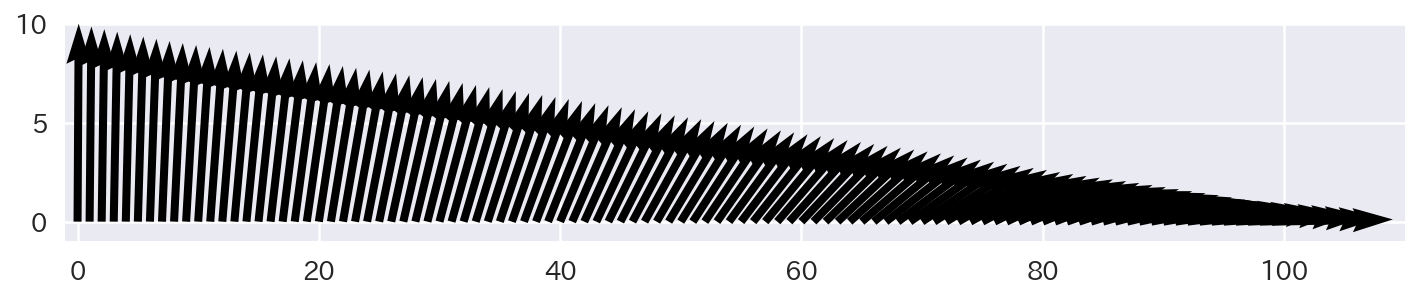

In [15]:
# 学習データに対する予測ベクトル
X = model.forward(x_train)
plt.figure(figsize=(12,2))
X = X.data
plt.quiver(X[:,0], X[:,1], angles='xy', scale_units='xy', scale=0.1)
plt.xlim([-1,110])
plt.ylim([-1,10])
plt.show()

In [16]:
new_input = []
for i in np.arange(0, 1, lin):
    new_input.append((aa-i)**2 + (bb-i)**2 + np.random.normal(0, 1))
new_input = np.array(new_input)

new_input = new_input.astype(np.float32)
new_input = new_input.reshape((len(new_input), 1, 100, 100))
new_X = model.forward(new_input)

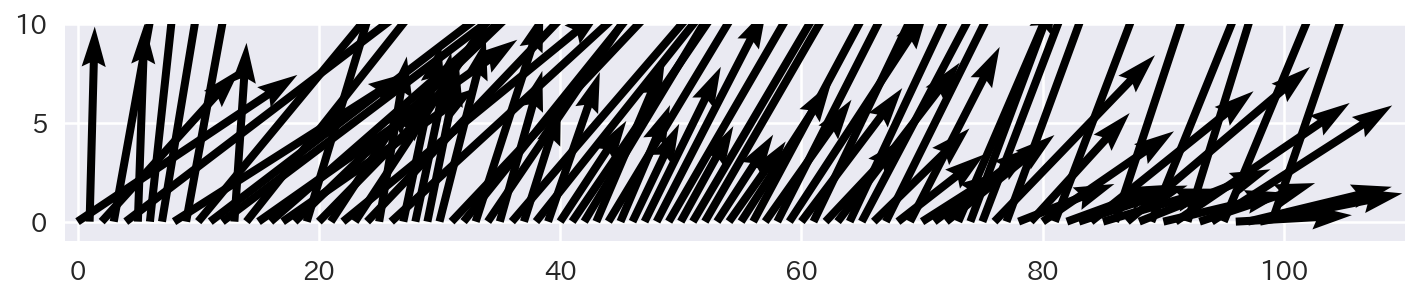

In [17]:
# 学習データに対する予測ベクトル
plt.figure(figsize=(12,2))
X = new_X.data
plt.quiver(X[:,0], X[:,1], angles='xy', scale_units='xy', scale=0.1)
plt.xlim([-1,110])
plt.ylim([-1,10])
plt.show()